# Machine Learning Project
## Predicting car prices using regression models

In [250]:
#import relevant libraries to be used
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import joblib 
%matplotlib inline

### Load and Read data

In [2]:
data = pd.read_csv('car_data.csv', encoding = "ISO-8859-1")
data.head()

,car,price,body,mileage,engV,engType,registration,year,model,drive
0,Ford,15500.0,crossover,68,2.5,Gas,yes,2010,Kuga,full
1,Mercedes-Benz,20500.0,sedan,173,1.8,Gas,yes,2011,E-Class,rear
2,Mercedes-Benz,35000.0,other,135,5.5,Petrol,yes,2008,CL 550,rear
3,Mercedes-Benz,17800.0,van,162,1.8,Diesel,yes,2012,B 180,front
4,Mercedes-Benz,33000.0,vagon,91,NaN,Other,yes,2013,E-Class,NaN


### Brief Data Insights

In [3]:
data.describe(include='all')

,car,price,body,mileage,engV,engType,registration,year,model,drive
count,9576,9576.000000,9576,9576.000000,9142.000000,9576,9576,9576.000000,9576,9065
unique,87,NaN,6,NaN,NaN,4,2,NaN,888,3
top,Volkswagen,NaN,sedan,NaN,NaN,Petrol,yes,NaN,E-Class,front
freq,936,NaN,3646,NaN,NaN,4379,9015,NaN,199,5188
mean,NaN,15633.317316,NaN,138.862364,2.646344,NaN,NaN,2006.605994,NaN,NaN
std,NaN,24106.523436,NaN,98.629754,5.927699,NaN,NaN,7.067924,NaN,NaN
min,NaN,0.000000,NaN,0.000000,0.100000,NaN,NaN,1953.000000,NaN,NaN
25%,NaN,4999.000000,NaN,70.000000,1.600000,NaN,NaN,2004.000000,NaN,NaN
50%,NaN,9200.000000,NaN,128.000000,2.000000,NaN,NaN,2008.000000,NaN,NaN
75%,NaN,16700.000000,NaN,194.000000,2.500000,NaN,NaN,2012.000000,NaN,NaN


In [4]:
data.info()
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9576 entries, 0 to 9575
Data columns (total 10 columns):
car             9576 non-null object
price           9576 non-null float64
body            9576 non-null object
mileage         9576 non-null int64
engV            9142 non-null float64
engType         9576 non-null object
registration    9576 non-null object
year            9576 non-null int64
model           9576 non-null object
drive           9065 non-null object
dtypes: float64(2), int64(2), object(6)
memory usage: 748.2+ KB


(9576, 10)

Dataset contains 9576 rows and 10 variables with essential meanings:
* car: manufacturer brand
* price: seller’s price in advertisement (in USD)
* body: car body type
* mileage: as mentioned in advertisement (‘000 Km)
* engV: rounded engine volume (‘000 cubic cm)
* engType: type of fuel (“Other” in this case should be treated as NA)
* registration: whether car registered or not
* year: year of production
* model: specific model name
* drive: drive type
#### In this Dataset, Price will be considered as the independent variable and the remaining 9 characteristics taken as the predictors

## Exploratory Data Analysis and Visualization
 
* split the data and use only train data for all visualizations 
* Check for any missing values in the data
* explore the outliers
* check on skewness of the attributes
* examine the correlation effects

### Spliting the data

In [5]:
#split data as a representative sample using stratified split
#Logically the year of making contibutes a big percentange to price predictions
#create a categorical year feature to be used in splits
data['year_cat'] = pd.cut(data['year'], bins=[0,1980,1990,2000,2010,2020], labels=[1,2,3,4,5])

from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for trainIndex, testIndex in split.split(data, data['year_cat']):
    strat_train_set = data.loc[trainIndex]
    strat_test_set = data.loc[testIndex]
print(strat_train_set.shape, strat_test_set.shape)

(7660, 11) (1916, 11)


In [6]:
# checking if the rationed samples in the statified set are a good representative of the all data
strat_data_rationed = (strat_test_set['year_cat'].value_counts()/len(strat_test_set))
original_data_rationed = (data['year_cat'].value_counts()/len(data))
rationed_data = pd.DataFrame(strat_data_rationed)
rationed_data['split_data'] = original_data_rationed
rationed_data['diff'] = (original_data_rationed - strat_data_rationed)
rationed_data['diff(%)'] = rationed_data['diff']*100/original_data_rationed
print(rationed_data)

   year_cat  split_data      diff   diff(%)
4  0.507307    0.507101 -0.000206 -0.040584
5  0.333507    0.333647  0.000139  0.041754
3  0.118476    0.118734  0.000258  0.217582
2  0.034447    0.034461  0.000014  0.041754
1  0.006263    0.006057 -0.000206 -3.405082


Notice that the rationed dataframe above the split data is a good representative set of the original data as shown with the small percentage differences

In [7]:
# after the above observation, the created year_cat category can now be removed from our data since it has no more contibution to the performance 
for set in (strat_train_set, strat_test_set):
    set.drop('year_cat',1, inplace=True)
print(strat_train_set.shape, strat_test_set.shape)

(7660, 10) (1916, 10)


### Summary Statistics

In [8]:
train_data = strat_train_set.copy()
train_data.describe(include='all')

,car,price,body,mileage,engV,engType,registration,year,model,drive
count,7660,7660.000000,7660,7660.000000,7315.000000,7660,7660,7660.000000,7660,7256
unique,83,NaN,6,NaN,NaN,4,2,NaN,831,3
top,Volkswagen,NaN,sedan,NaN,NaN,Petrol,yes,NaN,E-Class,front
freq,743,NaN,2883,NaN,NaN,3504,7191,NaN,161,4171
mean,NaN,15602.386934,NaN,138.520496,2.650960,NaN,NaN,2006.603786,NaN,NaN
std,NaN,24594.044975,NaN,97.813743,6.071285,NaN,NaN,7.092091,NaN,NaN
min,NaN,0.000000,NaN,0.000000,0.100000,NaN,NaN,1953.000000,NaN,NaN
25%,NaN,4900.000000,NaN,70.000000,1.600000,NaN,NaN,2004.000000,NaN,NaN
50%,NaN,9200.000000,NaN,127.000000,2.000000,NaN,NaN,2008.000000,NaN,NaN
75%,NaN,16700.000000,NaN,194.000000,2.500000,NaN,NaN,2012.000000,NaN,NaN


In [9]:
# the engType: has a category “Other” which is to be treated as NA)
train_data['engType'].replace('Other',np.nan, inplace=True)

### Observations
* Its observed that from the count values this data has some missing values in some columns (engV, and drive)
* Outliers do exist from observed maximum values in comparison to the upper quartile for price, mileage and engV and minmum values with lower quartile for year. 
* This can also be visualized below

### Check for availability of missing values 

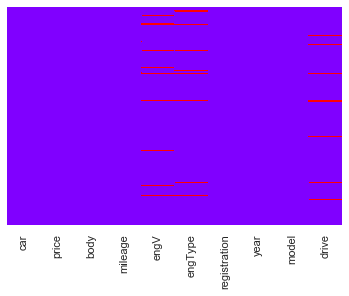

In [10]:
# Recall that the engType has a category “Other” which is to be treated as NA according to the original data description
# replace the 'Other' value with nan
train_data['engType'].replace('Other',np.nan, inplace=True)
sns.heatmap(train_data.isnull(),cbar=False,yticklabels=False,cmap = 'rainbow')
plt.show()

* So the missing values in the engV, engType and drive features are identified in figure being represented by red stripes shade on purple background.
* these missing values will be dealt with later on because there presence in the dataset will biase the results.

In [11]:
# the actual number of missing values in the identified features
train_data.isnull().sum()

car               0
price             0
body              0
mileage           0
engV            345
engType         368
registration      0
year              0
model             0
drive           404
dtype: int64

### Checking for the presence of outliers in the dataset

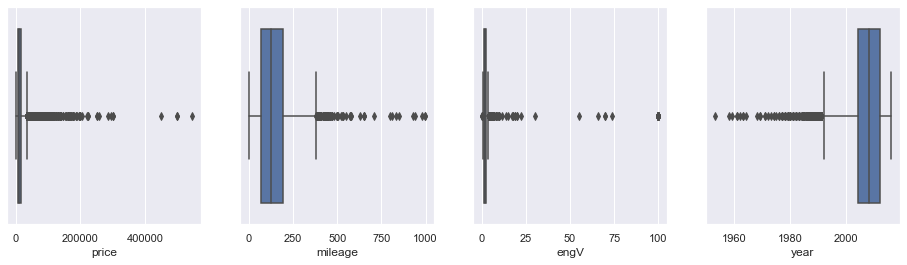

In [12]:
# visualizing outliers on boxplots
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(16,4))
sns.boxplot(x =train_data['price'], data=train_data, ax=ax1)
sns.boxplot(x= train_data['mileage'],  data=train_data, ax=ax2)
sns.boxplot(x=train_data['engV'],  data=train_data, ax=ax3)
sns.boxplot(x=train_data['year'],  data=train_data, ax=ax4)
plt.show()

* All the examined features possess outliers which are visualized with the extreme points off the limits in each boxplot
* these outliers will have to be reduced or completely eliminated later on for a better performance of the model

### Checking skewness

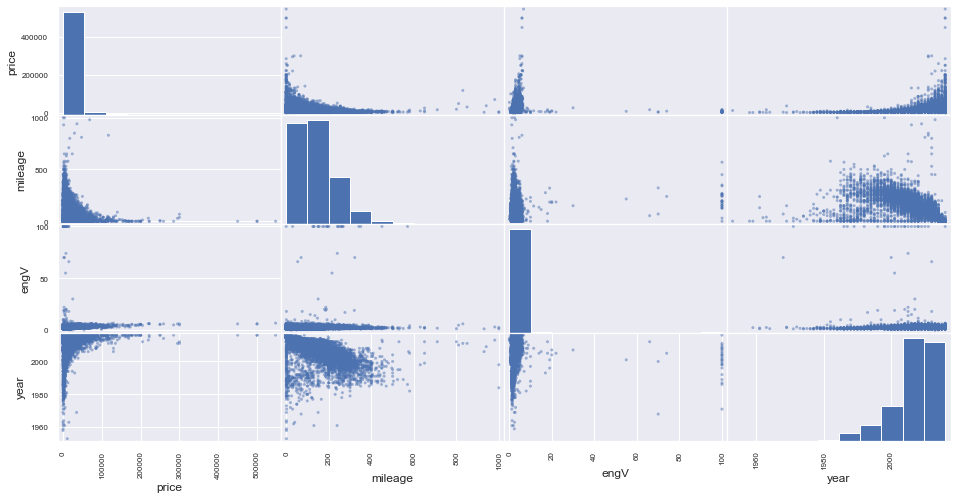

In [13]:
pd.plotting.scatter_matrix(train_data, diagonal='hist' , figsize=(16,8))
plt.show()

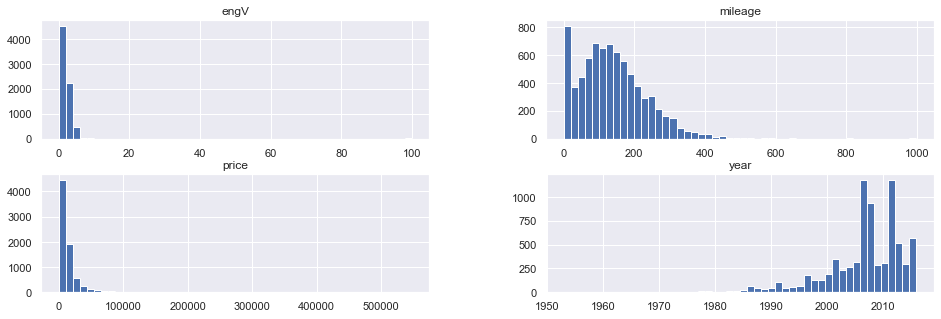

In [14]:
#histogram to check skewness of the data
train_data.hist(bins=50, figsize=(16,5))
plt.show()

* features are skewed confirming presence of outliers 
* will have to reduce the skewness by eliminating outliers and standardization for better predictions
* to check for linearity with the target(price), plot price against each of the features

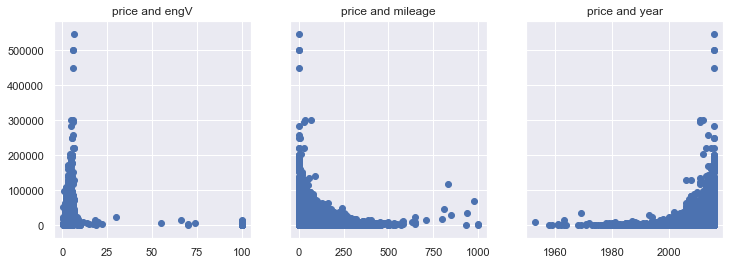

In [15]:
# checking target and numerical features for linearity
f, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(12,4))
ax1.scatter(train_data['engV'], train_data['price'])
ax1.set_title('price and engV')
ax2.scatter(train_data['mileage'], train_data['price'])
ax2.set_title('price and mileage')
ax3.scatter(train_data['year'], train_data['price'])
ax3.set_title('price and year')
plt.show()

* No linearity between features and the target instead and exponential relationship can be observed with year and mileage
* To improve on the predictions there is need to transform this data, a log transformation on price 

### To check correlation

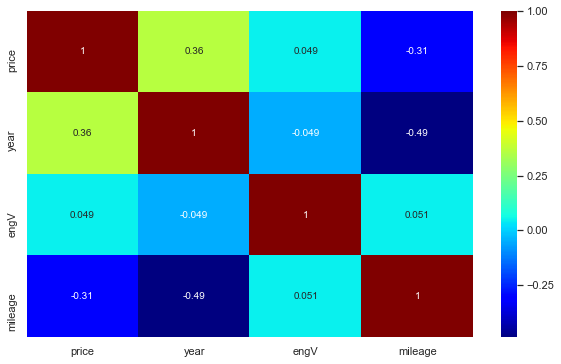

In [16]:
# correlation of data features
k=10
cols = train_data.corr().nlargest(k, 'price')['price'].index
cm = train_data[cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(cm, cmap='jet', annot=True)

* no highly correlated features observed

## Benchmark model
Linear regression is examined without prior data preprocessing

In [17]:
df1 = strat_train_set.copy()
print(df1.shape)
df2 = strat_test_set.copy()
print(df2.shape)
#concatenate the train df1 and test df2 , then apply get_dummies to create numerical for categorical features at once
data = pd.concat((df1,df2))
data= pd.get_dummies(data, drop_first=True)
print(data.shape)
# separate the two train(df11), and test(df22)
df11 = data.iloc[:7660, :]
df22= data.iloc[7660:, :]
print(df11.shape)
print(df22.shape)

(7660, 10)
(1916, 10)
(9576, 988)
(7660, 988)
(1916, 988)


In [18]:
df11= df11.fillna(df11.median())
inputs = df11.drop('price',1)
targets = df11.price.copy()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
mse = mean_squared_error
mae = mean_absolute_error
lin_reg = LinearRegression()
lin_reg.fit(inputs,targets)
ypred = lin_reg.predict(inputs)

print('score_train:',  lin_reg.score(inputs,targets) )
print('rmse_train:', np.sqrt(mse(targets, ypred)))
print('mae_train:', mae(targets, ypred))

df22 =df22.fillna(df22.median())
inputs_test = df22.drop('price',1)
targets_test = df22.price.copy()

ypred_test = lin_reg.predict(inputs_test)
targets2 = pd.DataFrame(targets_test)

print('score_test:', lin_reg.score(inputs_test,targets_test) )
print('rmse_test:', np.sqrt(mse(ypred_test,targets_test)))
print('mae_test:', mae(targets_test, ypred_test))

score_train: 0.7379870742771346
rmse_train: 12588.18077790926
mae_train: 5270.510432902775
score_test: 0.20585893545708334
rmse_test: 19649.65678262783
mae_test: 6871.612870902737


* The RMSE is much greater than the MAE in the train set; the greater difference between them, the greater the variance in the individual errors in the sample. the same is obtained even for the test set with very large numbers due to outliers.
* For a train set with a score of 73.7%, and test score of 20.6%, this and we need to tweak this data for better results.

## Data Preprocessing

In [19]:
train_data = strat_train_set.copy()
test_data = strat_test_set.copy()

### Taking care of the missing values

In [195]:
# create a class to fill missing values and log transform the target 
from sklearn.base import BaseEstimator, TransformerMixin
class no_missing_values(BaseEstimator, TransformerMixin):
    def fit(self, X):
        return self
    def transform(self, X, y=None):
        #X['log_price'] = np.log(X['price']) # transform the target attribute using log transformation
        X['engV']= X['engV'].fillna(X['engV'].median(axis=0))
        X['price'] =X['price'].replace(0, X['price'].mean())
        X= X.dropna() #engType, drive missing values will be dropped
        X['log_price'] = np.log(X['price']) # transform the target attribute using log transformation
        return X
train_no_mv = no_missing_values().fit_transform(train_data)
print(train_no_mv.shape)
train_no_mv[0:100]

(7256, 11)


C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,car,price,body,mileage,engV,engType,registration,year,model,drive,log_price
5507,Toyota,25555.000000,crossover,128,4.70,Gas,yes,2004,Land Cruiser 100,full,10.148588
3088,Honda,12100.000000,hatch,95,1.80,Petrol,yes,2010,Civic,front,9.400961
8310,Volkswagen,3100.000000,hatch,311,1.60,Gas,yes,1986,Golf II,full,8.039157
2995,Hyundai,8999.000000,hatch,56,1.60,Petrol,yes,2010,i30,front,9.104869
6771,Mercedes-Benz,11777.000000,other,300,4.30,Gas,yes,2001,S 430,rear,9.373904
1777,Mazda,11800.000000,crossover,165,2.30,Petrol,yes,2008,CX-7,front,9.375855
4455,Skoda,7750.000000,vagon,109,2.00,Petrol,yes,2001,Octavia Tour,front,8.955448
180,BMW,15602.386934,crossover,36,3.00,Diesel,yes,2013,X5,full,9.655179
1682,Land Rover,39700.000000,crossover,87,2.00,Petrol,yes,2010,Range Rover,full,10.589106
9281,Subaru,18700.000000,crossover,98,2.50,Petrol,yes,2011,Outback,full,9.836279


## Dealing with the outliers

In [196]:
#class to remove outliers
class remove_outliers(BaseEstimator, TransformerMixin):
    def fit(self,X):
        return self
    def transform(self,X,y=None):
        X = X[(X['price'] < 200000 ) ].reset_index(drop=True)
        X = X[(X['mileage'] < 500 ) ].reset_index(drop=True)
        X = X[(X['engV'] < 7 ) ].reset_index(drop=True)
        X = X[(X['year'] > 1980 ) ].reset_index(drop=True)
        X = X.drop('price', 1) # remove original target attribute, Price
        #X = X.drop('mileage', 1) # remove original mileage attribute, Price
        #X = X.dropna()
        X = X.reset_index(drop=True)
        return X
train_no_outliers = remove_outliers().fit_transform(train_no_mv)
train_no_outliers.shape

(7130, 10)

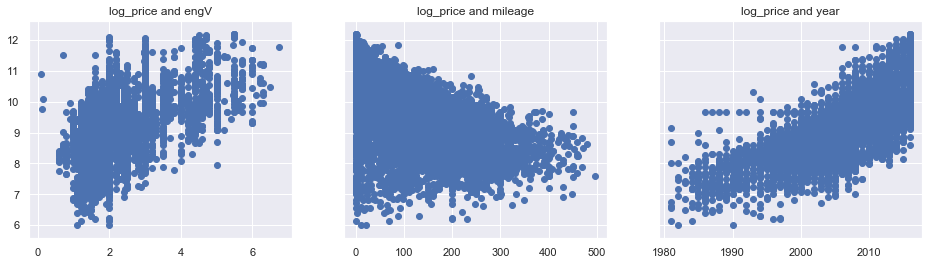

In [197]:
# subplots on transformed target(log_Price) and the numerical features
f, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16,4))
ax1.scatter(train_no_outliers['engV'], train_no_outliers['log_price'])
ax1.set_title('log_price and engV')
ax2.scatter(train_no_outliers['mileage'], train_no_outliers['log_price'])
ax2.set_title('log_price and mileage')
ax3.scatter(train_no_outliers['year'], train_no_outliers['log_price'])
ax3.set_title('log_price and year')
plt.show()

Linerarity can be observed with engV and year, but not clearly with mileage, standardization will be applied to create homoscedacity

## Pipelines

In [198]:
# create a numerical pipepline and categorical pipeline
train_inputs = train_no_outliers.drop('log_price',1)
train_targets = train_no_outliers.log_price
num_train_attr = ['mileage', 'engV', 'year']
num_train = train_inputs[num_train_attr]
cat_train = train_inputs.drop(num_train,1)

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

#clean_data_pipeline = Pipeline([
#    ('missing_values', no_missing_values()),
#   ('outliers', remove_outliers()),
#])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),    
])

cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown ='ignore'))
])
#total_attributes = list(train_data)
num_attributes = list(num_train)
cat_attributes = list(cat_train)
#print(total_attributes)
print(num_attributes)
print(cat_attributes)

full_pipeline = ColumnTransformer([
#    ('cleaned_data', clean_data_pipeline, total_attributes),
    ('num', num_pipeline, num_attributes),
    ('cat', cat_pipeline, cat_attributes)
])

processed_train_inputs = full_pipeline.fit_transform(train_inputs)
print(processed_train_inputs.toarray())
processed_train_inputs

['mileage', 'engV', 'year']
['car', 'body', 'engType', 'registration', 'model', 'drive']
[[-0.10264516  2.6378272  -0.43863588 ...  0.          1.
   0.        ]
 [-0.46424148 -0.45488104  0.48030844 ...  1.          0.
   0.        ]
 [ 1.90257078 -0.66817126 -3.19546886 ...  0.          1.
   0.        ]
 ...
 [ 2.54906116  0.29163474 -1.35758021 ...  1.          0.
   0.        ]
 [-0.03690037  0.8248603   0.48030844 ...  0.          0.
   1.        ]
 [-0.7929654  -1.52133216  0.02083628 ...  1.          0.
   0.        ]]


<7130x883 sparse matrix of type '<class 'numpy.float64'>'
	with 64170 stored elements in Compressed Sparse Row format>

## Train and Test the model

In [199]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [208]:
models = [
           ['linear Regression:', LinearRegression()],
           ['SVR:' , SVR(kernel='rbf', gamma='auto')],
           ['Decision_tree:', DecisionTreeRegressor()],
           ['RandomForest: ',RandomForestRegressor(n_estimators=10)],
           ['ExtraTreeRegressor :',ExtraTreesRegressor(n_estimators=10)],
           ['AdaBoostRegressor: ', AdaBoostRegressor()],
           ['GradientBoostingRegressor: ', GradientBoostingRegressor()] 
         ]

In [209]:
test_data = strat_test_set.copy()
test_no_mv = no_missing_values().transform(test_data)
test_outliers = remove_outliers().transform(test_no_mv)
test_inputs = test_outliers.drop('log_price',1)
test_targets = test_outliers.log_price
processed_test_inputs = full_pipeline.transform(test_inputs)
processed_test_inputs

C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


<1773x883 sparse matrix of type '<class 'numpy.float64'>'
	with 15888 stored elements in Compressed Sparse Row format>

In [210]:
#create a function results to display all test and train values in a dataframe
def models_evaluation():
    import time
    from sklearn.metrics import r2_score
    model_results = []
    for name, active_model in models :
        active_model_data = {}
        active_model.random_state = 42
        active_model_data["Name"] = name
        start = time.time()
        active_model.fit(processed_train_inputs, train_targets)
        end = time.time()
       
        active_model_data["R2_Score_Train"] = r2_score(train_targets, active_model.predict(processed_train_inputs)).round(3)
        active_model_data["Training_Time"] = end - start
        active_model_data["RMSE_Train"] = np.sqrt(mean_squared_error(train_targets, active_model.predict(processed_train_inputs))).round(3)
        
        active_model_data["R2_Score_test"] = r2_score(test_targets, active_model.predict(processed_test_inputs)).round(3)
        active_model_data["RMSE_test"] = np.sqrt(mean_squared_error(test_targets, active_model.predict(processed_test_inputs))).round(3)
        model_results.append(active_model_data)
    model_results = pd.DataFrame(model_results)
    return(model_results)
models_evaluation().set_index(['Name'])

,R2_Score_Train,R2_Score_test,RMSE_Train,RMSE_test,Training_Time
Name,,,,,
linear Regression:,0.913,0.889,0.276,0.309,0.412297
SVR:,0.834,0.841,0.381,0.369,3.683292
Decision_tree:,0.991,0.822,0.090,0.391,0.576880
RandomForest:,0.968,0.873,0.166,0.330,4.088228
ExtraTreeRegressor :,0.991,0.865,0.090,0.340,5.369617
AdaBoostRegressor:,0.725,0.729,0.491,0.482,0.979664
GradientBoostingRegressor:,0.875,0.874,0.330,0.328,1.018693


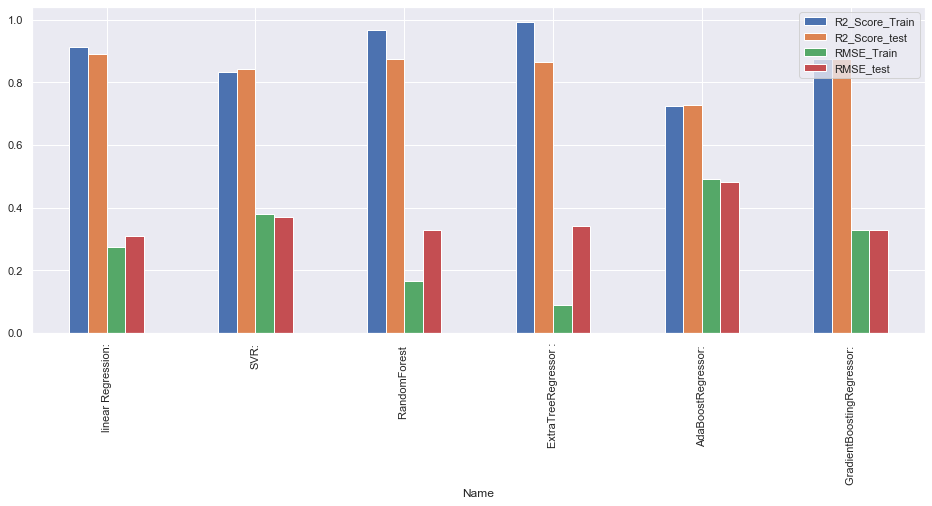

In [203]:
models_evaluation().columns.values
model_df = models_evaluation().set_index(['Name'])
model_df = model_df.drop('Training_Time', 1)
model_df.plot(kind='bar', figsize=(16,6))
plt.show()

* The Evaluation of all the used models identifies Extremely randomized trees regression model as the  best model on the train data with the highest score of 99.1% lowest unexplained values rmse of 0.09 and AdaBoost regression model as the worst performer.
* In the search of a best model to use on the test dataset, the ExtraTreesRegressor model is selected and will be fine tuned to regularize it and avoid over fitting.

## Fine Tune the best model

In [211]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators' : [200,300,400],
    'max_features' : ['auto','sqrt'],
    'max_depth' : [None,30]
}
extra_tree_reg = ExtraTreesRegressor(random_state=42)
grid_search = GridSearchCV(extra_tree_reg, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1, return_train_score=True)


In [214]:
#fit model
grid_search.fit(processed_train_inputs, train_targets)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'max_depth': 30, 'max_features': 'auto', 'n_estimators': 400}
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=30,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=None,
                    oob_score=False, random_state=42, verbose=0,
                    warm_start=False)


In [215]:
from sklearn.externals import joblib 
  
# Save the model as a pickle in a file new_model 
joblib.dump(grid_search, 'new_model.pkl') 

['new_model.pkl']

In [216]:
# Load the model from the file 
best_model_joblib = joblib.load('new_model.pkl')  
  
# Use the loaded model to make predictions 
best_model_joblib.predict(processed_test_inputs) 

array([ 9.65452393,  8.36843641, 11.20618156, ...,  8.85612335,
        9.78671825, 10.18656223])

In [217]:
print(best_model_joblib.best_params_)
print(best_model_joblib.best_estimator_)

{'max_depth': 30, 'max_features': 'auto', 'n_estimators': 400}
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=30,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=None,
                    oob_score=False, random_state=42, verbose=0,
                    warm_start=False)


In [219]:
processed_test_inputs = full_pipeline.transform(test_inputs)
test_pred = best_model_joblib.best_estimator_.predict(processed_test_inputs)
print(test_pred.shape)
print(test_targets.shape)
pf_df = pd.DataFrame(test_targets)
pf_df['test_targets'] = np.exp(pf_df['log_price'])
pf_df['test_pred'] = np.exp(test_pred)
pf_df['test_residual'] = np.abs(pf_df['test_targets'] - pf_df['test_pred']).round(4)
pf_df['diff%'] = (pf_df['test_residual']*100/pf_df['test_targets']).round(3)
pd.options.display.max_rows = None
print(pf_df.sort_values(by='diff%'))

(1773,)
(1773,)
      log_price   test_targets      test_pred  test_residual    diff%
529   10.414303   33333.000000   33333.000000         0.0000    0.000
1055   9.928180   20500.000000   20500.000000         0.0000    0.000
1550  10.085767   23999.000000   23997.745709         1.2543    0.005
1319   9.705037   16400.000000   16397.886095         2.1139    0.013
907    9.539644   13900.000000   13903.048163         3.0482    0.022
1221   7.782807    2399.000000    2400.000000         1.0000    0.042
375   10.594132   39900.000000   39882.203741        17.7963    0.045
1285  10.077441   23800.000000   23810.864983        10.8650    0.046
1705  10.925129   55555.000000   55519.004241        35.9958    0.065
1208  10.925129   55555.000000   55519.004241        35.9958    0.065
1036   7.901007    2700.000000    2702.442586         2.4426    0.090
15    10.477288   35500.000000   35461.745071        38.2549    0.108
1623   9.179881    9700.000000    9711.655287        11.6553    0.120
511 

### scatter plot of predicted prices vs actual prices

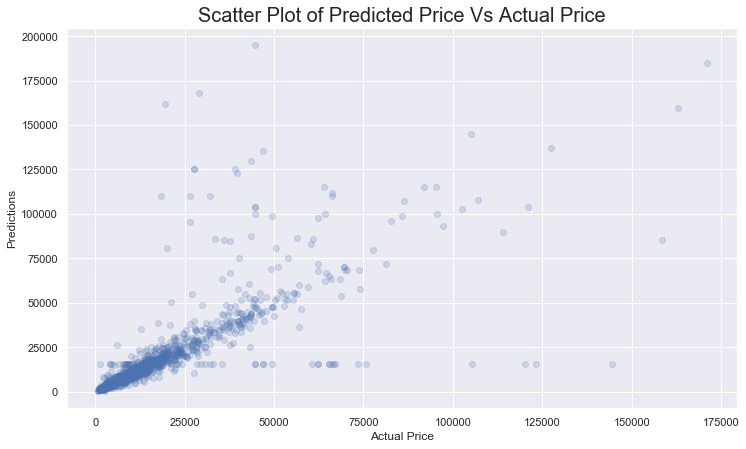

In [220]:
plt.figure(figsize=(12,7))
plt.scatter(pf_df['test_pred'], pf_df['test_targets'], alpha=0.2)
plt.title('Scatter Plot of Predicted Price Vs Actual Price', y=1, size=20)
plt.grid(True)
plt.xlabel("Actual Price")
plt.ylabel("Predictions")
plt.show()

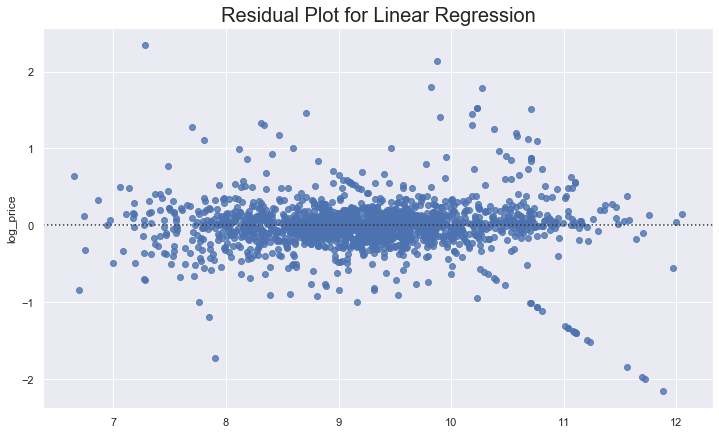

In [221]:
plt.figure(figsize=(12,7)) 
plt.grid(True)
plt.title('Residual Plot for Linear Regression', y=1, size=20) 
sns.residplot(test_pred,test_targets)

In [223]:
from sklearn.metrics import r2_score
rmse_train= np.sqrt(mean_squared_error(np.exp(train_targets), np.exp(best_model_joblib.best_estimator_.predict(processed_train_inputs))).round(3))
score_train = 100*r2_score(train_targets, best_model_joblib.best_estimator_.predict(processed_train_inputs)).round(3)
rmse_test = np.sqrt(mean_squared_error(np.exp(test_targets), np.exp(best_model_joblib.best_estimator_.predict(processed_test_inputs))).round(3))
score_test = 100*r2_score(test_targets, best_model_joblib.best_estimator_.predict(processed_test_inputs)).round(3)

final_results = pd.DataFrame(data= ['rmse_test', 'score_test', 'rmse_train', 'score_train'], columns=['metrics'])
final_results['values'] = rmse_test, score_test, rmse_train, score_train
print('Final evaluation')
print(final_results)

Final evaluation
       metrics        values
0    rmse_test  12696.303650
1   score_test     87.500000
2   rmse_train   5583.808827
3  score_train     98.800000


This resulting model doesn't show much improvement in overcoming the overfitting as expected after scoring 98.8% on train sample and only 87.5% on test sample, it will be compared with other models on the test data for better results

### For regression model on test sample

In [224]:
lin_reg2= LinearRegression()
lin_reg2.fit(processed_train_inputs, train_targets)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [240]:
print('score_train:',  lin_reg2.score(processed_train_inputs,train_targets) )
print('rmse_train:', np.sqrt(mse(np.exp(train_targets), np.exp(lin_reg2.predict(processed_train_inputs)))))
print('mae_train:', mae(np.exp(train_targets), np.exp(lin_reg2.predict(processed_train_inputs))))

score_train: 0.9131116680460456
rmse_train: 9934.232399469442
mae_train: 3271.249004275782


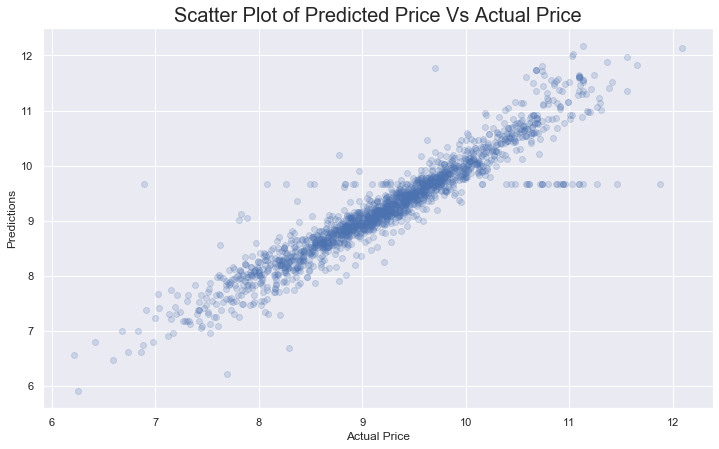

In [241]:
train_predictions = (lin_reg2.predict(processed_train_inputs))
test_predictions = (lin_reg2.predict(processed_test_inputs))                         
plt.figure(figsize=(12,7))
plt.scatter(test_predictions, (test_targets), alpha=0.2)
plt.title('Scatter Plot of Predicted Price Vs Actual Price', y=1, size=20)
plt.grid(True)
plt.xlabel("Actual Price")
plt.ylabel("Predictions")
plt.show()

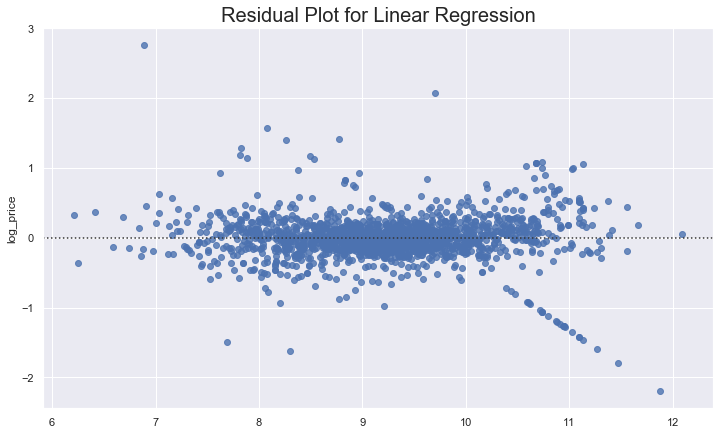

In [242]:
plt.figure(figsize=(12,7)) 
plt.grid(True)
plt.title('Residual Plot for Linear Regression', y=1, size=20) 
sns.residplot(test_predictions,test_targets)

In [248]:
prediction_df  = pd.DataFrame(test_targets)
prediction_df['test_targets'] = np.exp(prediction_df['log_price']).round(2)
prediction_df['test_predictions'] = np.exp(test_predictions).round(2)
prediction_df['test_residual'] = np.abs(prediction_df['test_targets'] - prediction_df['test_predictions']).round(4)
prediction_df['diff%'] = (prediction_df['test_residual']*100/prediction_df['test_targets']).round(3)
pd.options.display.max_rows = None
print(prediction_df.sort_values(by='diff%'))

      log_price  test_targets  test_predictions  test_residual    diff%
157    9.852194      19000.00          19004.47           4.47    0.024
929    9.661416      15700.00          15704.50           4.50    0.029
1221   7.782807       2399.00           2399.99           0.99    0.041
828    9.305651      11000.00          10995.26           4.74    0.043
795    9.506734      13450.00          13459.21           9.21    0.068
916    9.296518      10900.00          10908.97           8.97    0.082
896    9.913438      20200.00          20181.83          18.17    0.090
63     9.574983      14400.00          14384.52          15.48    0.108
430   10.024087      22563.45          22592.39          28.94    0.128
79     8.160518       3500.00           3494.44           5.56    0.159
90     9.071078       8700.00           8714.29          14.29    0.164
810    8.895630       7300.00           7287.98          12.02    0.165
1556   9.602382      14800.00          14773.89          26.11  

In [249]:
print('score_test:',  lin_reg2.score(processed_test_inputs,test_targets) )
print('rmse_test:', np.sqrt(mse(np.exp(test_targets), np.exp(lin_reg2.predict(processed_test_inputs)))))
print('mae_test:', mae(np.exp(test_targets), np.exp(lin_reg2.predict(processed_test_inputs))))

score_test: 0.8887332819687164
rmse_test: 11428.8471930471
mae_test: 3946.9517820603833


## Final prediction and Conclusion

* A fine tuned ExtraTreeRegressor model scores 98.8% on train data but only 87.5% on the test data However, the linear Regression model scores 91.3% on train data and 88.9% on the test data.
* Since the ExtraTreeRessor model fails to out compete the LinearRegression Model on the test sample as it does with the train data, Linear Ression model is more desirable for better predictions.
* Our Linear Regression model is able to give 88.9% a very big improvement 20.6% obtained from the benchmark model.
* The root mean square error determined is 11429 much better than the 19647 from the benchmark model.
* The original data leaves out many other attributes that rationally affect the prices of cars and this does explain the failure to achieve a much higher score. Vehicle condition(damaged or normal state), Engine horse power,driven wheels,market category, transmission type, would be a great attributes in determining prices but were not available.